Creator: Dhanajit Brahma

Adapted from the original implementation in tensorflow from here: https://github.com/jsyoon0823/GAIN

Generative Adversarial Imputation Networks (GAIN) Implementation on Letter and Spam Dataset

Reference: J. Yoon, J. Jordon, M. van der Schaar, "GAIN: Missing Data Imputation using Generative Adversarial Nets," ICML, 2018.

In [1]:
#%% Packages
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
dataset_file = '/Users/gabrielketron/tpot2_addimputers/tpot2/ImputerExperiments/data/Spam.csv'  # 'Letter.csv' for Letter dataset an 'Spam.csv' for Spam dataset
use_gpu = False  # set it to True to use GPU and False to use CPU
if use_gpu:
    torch.cuda.set_device(0)

In [3]:
#%% System Parameters
# 1. Mini batch size
mb_size = 128
# 2. Missing rate
p_miss = 0.2
# 3. Hint rate
p_hint = 0.9
# 4. Loss Hyperparameters
alpha = 10
# 5. Train Rate
train_rate = 0.8

#%% Data

# Data generation
Data = np.loadtxt(dataset_file, delimiter=",",skiprows=1)

# Parameters
No = len(Data)
Dim = len(Data[0,:])

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

    
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(No * train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

#%% Necessary Functions

# 1. Xavier Initialization Definition
# def xavier_init(size):
#     in_dim = size[0]
#     xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
#     return tf.random_normal(shape = size, stddev = xavier_stddev)
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return np.random.normal(size = size, scale = xavier_stddev)
    
# Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C
   

### GAIN Architecture   
GAIN Consists of 3 Components
- Generator
- Discriminator
- Hint Mechanism

In [4]:
#%% 1. Discriminator
if use_gpu is True:
    D_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True, device="cuda")     # Data + Hint as inputs
    D_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True, device="cuda")

    D_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True, device="cuda")
    D_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True, device="cuda")

    D_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True, device="cuda")
    D_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True, device="cuda")       # Output is multi-variate
else:
    D_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True)     # Data + Hint as inputs
    D_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True)

    D_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True)
    D_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True)

    D_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True)
    D_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True)       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

#%% 2. Generator
if use_gpu is True:
    G_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True, device="cuda")     # Data + Mask as inputs (Random Noises are in Missing Components)
    G_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True, device="cuda")

    G_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True, device="cuda")
    G_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True, device="cuda")

    G_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True, device="cuda")
    G_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True, device="cuda")
else:
    G_W1 = torch.tensor(xavier_init([Dim*2, H_Dim1]),requires_grad=True)     # Data + Mask as inputs (Random Noises are in Missing Components)
    G_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True)

    G_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]),requires_grad=True)
    G_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True)

    G_W3 = torch.tensor(xavier_init([H_Dim2, Dim]),requires_grad=True)
    G_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True)

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

## GAIN Functions

In [5]:
#%% 1. Generator
def generator(new_x,m):
    inputs = torch.cat(dim = 1, tensors = [new_x,m])  # Mask + Data Concatenate
    G_h1 = F.relu(torch.matmul(inputs, G_W1) + G_b1)
    G_h2 = F.relu(torch.matmul(G_h1, G_W2) + G_b2)   
    G_prob = torch.sigmoid(torch.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    
    return G_prob

#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = torch.cat(dim = 1, tensors = [new_x,h])  # Hint + Data Concatenate
    D_h1 = F.relu(torch.matmul(inputs, D_W1) + D_b1)  
    D_h2 = F.relu(torch.matmul(D_h1, D_W2) + D_b2)
    D_logit = torch.matmul(D_h2, D_W3) + D_b3
    D_prob = torch.sigmoid(D_logit)  # [0,1] Probability Output
    
    return D_prob

#%% 3. Other functions
# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])        

# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

## GAIN Losses

In [6]:
def discriminator_loss(M, New_X, H):
    # Generator
    G_sample = generator(New_X,M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_New_X, H)

    #%% Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss

def generator_loss(X, M, New_X, H):
    #%% Structure
    # Generator
    G_sample = generator(New_X,M)

    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_New_X, H)

    #%% Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)

    G_loss = G_loss1 + alpha * MSE_train_loss 

    #%% MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss
    
def test_loss(X, M, New_X):
    #%% Structure
    # Generator
    G_sample = generator(New_X,M)

    #%% MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

## Optimizers

In [7]:
optimizer_D = torch.optim.Adam(params=theta_D)
optimizer_G = torch.optim.Adam(params=theta_G)

## Training

In [8]:
#%% Start Iterations
for it in tqdm(range(5000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
    M_mb = trainM[mb_idx,:]  
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device="cuda")
        M_mb = torch.tensor(M_mb, device="cuda")
        H_mb = torch.tensor(H_mb, device="cuda")
        New_X_mb = torch.tensor(New_X_mb, device="cuda")
    else:
        X_mb = torch.tensor(X_mb)
        M_mb = torch.tensor(M_mb)
        H_mb = torch.tensor(H_mb)
        New_X_mb = torch.tensor(New_X_mb)
    
    optimizer_D.zero_grad()
    D_loss_curr = discriminator_loss(M=M_mb, New_X=New_X_mb, H=H_mb)
    D_loss_curr.backward()
    optimizer_D.step()
    
    optimizer_G.zero_grad()
    G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = generator_loss(X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb)
    G_loss_curr.backward()
    optimizer_G.step()    
        
    #%% Intermediate Losses
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr.item())))
        print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr.item())))
        print()

  2%|▏         | 88/5000 [00:00<00:11, 441.55it/s]

Iter: 0
Train_loss: 0.5158
Test_loss: 0.5188



  3%|▎         | 133/5000 [00:00<00:12, 384.98it/s]

Iter: 100
Train_loss: 0.05808
Test_loss: 0.0545



  5%|▌         | 258/5000 [00:00<00:13, 360.48it/s]

Iter: 200
Train_loss: 0.0538
Test_loss: 0.05068



  8%|▊         | 376/5000 [00:00<00:12, 375.78it/s]

Iter: 300
Train_loss: 0.06115
Test_loss: 0.05914



  9%|▉         | 457/5000 [00:01<00:12, 356.85it/s]

Iter: 400
Train_loss: 0.06275
Test_loss: 0.06081



 11%|█         | 541/5000 [00:01<00:11, 384.54it/s]

Iter: 500
Train_loss: 0.05074
Test_loss: 0.04955



 13%|█▎        | 674/5000 [00:01<00:10, 418.85it/s]

Iter: 600
Train_loss: 0.05999
Test_loss: 0.05863



 15%|█▌        | 763/5000 [00:01<00:09, 431.00it/s]

Iter: 700
Train_loss: 0.0485
Test_loss: 0.06783



 17%|█▋        | 855/5000 [00:02<00:09, 441.97it/s]

Iter: 800
Train_loss: 0.05263
Test_loss: 0.04699



 19%|█▉        | 949/5000 [00:02<00:09, 439.67it/s]

Iter: 900
Train_loss: 0.05028
Test_loss: 0.06122



 22%|██▏       | 1094/5000 [00:02<00:08, 461.92it/s]

Iter: 1000
Train_loss: 0.05144
Test_loss: 0.06054



 24%|██▍       | 1190/5000 [00:02<00:08, 465.12it/s]

Iter: 1100
Train_loss: 0.05412
Test_loss: 0.05081



 26%|██▌       | 1285/5000 [00:03<00:08, 454.31it/s]

Iter: 1200
Train_loss: 0.04881
Test_loss: 0.0545



 28%|██▊       | 1380/5000 [00:03<00:07, 463.32it/s]

Iter: 1300
Train_loss: 0.04552
Test_loss: 0.05873



 29%|██▉       | 1472/5000 [00:03<00:08, 424.41it/s]

Iter: 1400
Train_loss: 0.04274
Test_loss: 0.06087



 31%|███▏      | 1566/5000 [00:03<00:07, 443.96it/s]

Iter: 1500
Train_loss: 0.04222
Test_loss: 0.04433



 33%|███▎      | 1660/5000 [00:03<00:07, 456.16it/s]

Iter: 1600
Train_loss: 0.04274
Test_loss: 0.05668



 35%|███▌      | 1755/5000 [00:04<00:06, 463.84it/s]

Iter: 1700
Train_loss: 0.04273
Test_loss: 0.05793



 37%|███▋      | 1853/5000 [00:04<00:06, 462.14it/s]

Iter: 1800
Train_loss: 0.03984
Test_loss: 0.05007



 39%|███▉      | 1948/5000 [00:04<00:06, 445.76it/s]

Iter: 1900
Train_loss: 0.03442
Test_loss: 0.05378



 41%|████      | 2043/5000 [00:04<00:06, 441.59it/s]

Iter: 2000
Train_loss: 0.03352
Test_loss: 0.05143



 44%|████▍     | 2189/5000 [00:05<00:06, 467.07it/s]

Iter: 2100
Train_loss: 0.03428
Test_loss: 0.04975



 46%|████▌     | 2284/5000 [00:05<00:05, 463.05it/s]

Iter: 2200
Train_loss: 0.03292
Test_loss: 0.05255



 48%|████▊     | 2378/5000 [00:05<00:05, 454.95it/s]

Iter: 2300
Train_loss: 0.02758
Test_loss: 0.05088



 49%|████▉     | 2471/5000 [00:05<00:05, 431.31it/s]

Iter: 2400
Train_loss: 0.03235
Test_loss: 0.05737



 51%|█████▏    | 2565/5000 [00:05<00:05, 448.12it/s]

Iter: 2500
Train_loss: 0.03353
Test_loss: 0.04674



 53%|█████▎    | 2656/5000 [00:06<00:05, 444.66it/s]

Iter: 2600
Train_loss: 0.0309
Test_loss: 0.05964



 55%|█████▌    | 2751/5000 [00:06<00:05, 437.38it/s]

Iter: 2700
Train_loss: 0.02715
Test_loss: 0.05795



 58%|█████▊    | 2881/5000 [00:06<00:05, 416.14it/s]

Iter: 2800
Train_loss: 0.03021
Test_loss: 0.05065



 59%|█████▉    | 2967/5000 [00:06<00:04, 421.50it/s]

Iter: 2900
Train_loss: 0.0292
Test_loss: 0.06192



 61%|██████    | 3060/5000 [00:07<00:04, 443.23it/s]

Iter: 3000
Train_loss: 0.02648
Test_loss: 0.05452



 63%|██████▎   | 3155/5000 [00:07<00:04, 454.91it/s]

Iter: 3100
Train_loss: 0.02519
Test_loss: 0.05174



 65%|██████▍   | 3247/5000 [00:07<00:03, 452.37it/s]

Iter: 3200
Train_loss: 0.02764
Test_loss: 0.04973



 68%|██████▊   | 3394/5000 [00:07<00:03, 472.05it/s]

Iter: 3300
Train_loss: 0.02434
Test_loss: 0.05232



 69%|██████▉   | 3442/5000 [00:07<00:03, 433.38it/s]

Iter: 3400
Train_loss: 0.03
Test_loss: 0.06014



 72%|███████▏  | 3585/5000 [00:08<00:03, 458.99it/s]

Iter: 3500
Train_loss: 0.0269
Test_loss: 0.04678



 74%|███████▎  | 3681/5000 [00:08<00:02, 462.42it/s]

Iter: 3600
Train_loss: 0.02455
Test_loss: 0.05256



 75%|███████▌  | 3773/5000 [00:08<00:02, 437.83it/s]

Iter: 3700
Train_loss: 0.02507
Test_loss: 0.05267



 77%|███████▋  | 3869/5000 [00:08<00:02, 459.03it/s]

Iter: 3800
Train_loss: 0.02464
Test_loss: 0.06597



 79%|███████▉  | 3964/5000 [00:09<00:02, 463.68it/s]

Iter: 3900
Train_loss: 0.02419
Test_loss: 0.05976



 81%|████████  | 4059/5000 [00:09<00:02, 442.97it/s]

Iter: 4000
Train_loss: 0.02421
Test_loss: 0.05306



 83%|████████▎ | 4149/5000 [00:09<00:01, 442.79it/s]

Iter: 4100
Train_loss: 0.0226
Test_loss: 0.04916



 86%|████████▌ | 4289/5000 [00:09<00:01, 454.79it/s]

Iter: 4200
Train_loss: 0.02527
Test_loss: 0.04813



 87%|████████▋ | 4336/5000 [00:09<00:01, 457.35it/s]

Iter: 4300
Train_loss: 0.02271
Test_loss: 0.06062



 90%|████████▉ | 4479/5000 [00:10<00:01, 446.38it/s]

Iter: 4400
Train_loss: 0.02222
Test_loss: 0.05249



 92%|█████████▏| 4575/5000 [00:10<00:00, 460.30it/s]

Iter: 4500
Train_loss: 0.02225
Test_loss: 0.0592



 93%|█████████▎| 4673/5000 [00:10<00:00, 472.48it/s]

Iter: 4600
Train_loss: 0.02693
Test_loss: 0.05673



 95%|█████████▌| 4768/5000 [00:10<00:00, 450.22it/s]

Iter: 4700
Train_loss: 0.02231
Test_loss: 0.06395



 97%|█████████▋| 4862/5000 [00:11<00:00, 436.42it/s]

Iter: 4800
Train_loss: 0.0235
Test_loss: 0.06084



 99%|█████████▉| 4957/5000 [00:11<00:00, 437.50it/s]

Iter: 4900
Train_loss: 0.0229
Test_loss: 0.05741



100%|██████████| 5000/5000 [00:11<00:00, 437.79it/s]


## Testing

In [9]:
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

if use_gpu is True:
    X_mb = torch.tensor(X_mb, device='cuda')
    M_mb = torch.tensor(M_mb, device='cuda')
    New_X_mb = torch.tensor(New_X_mb, device='cuda')
else:
    X_mb = torch.tensor(X_mb)
    M_mb = torch.tensor(M_mb)
    New_X_mb = torch.tensor(New_X_mb)
    
MSE_final, Sample = test_loss(X=X_mb, M=M_mb, New_X=New_X_mb)
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final.item())))

Final Test RMSE: 0.05326744178163777


In [10]:
imputed_data = M_mb * X_mb + (1-M_mb) * Sample
print("Imputed test data:")
# np.set_printoptions(formatter={'float': lambda x: "{0:0.8f}".format(x)})

if use_gpu is True:
    print(imputed_data.cpu().detach().numpy())
else:
    print(imputed_data.detach().numpy())

Imputed test data:
[[0.00000000e+00 0.00000000e+00 5.90227679e-02 ... 6.68857704e-03
  3.80456548e-03 2.28080270e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90649115e-04
  3.79778740e-03 4.29292929e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.34543804e-03
  1.52475242e-04 8.42976060e-03]
 ...
 [0.00000000e+00 3.88542850e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.52525253e-04]
 [7.25846808e-03 0.00000000e+00 0.00000000e+00 ... 6.89968225e-05
  1.00120144e-04 8.20707071e-04]
 [0.00000000e+00 1.22406508e-02 0.00000000e+00 ... 4.80254198e-04
  3.00360432e-04 5.90242456e-03]]


/Users/gabrielketron/tpot2_addimputers/env2/lib/python3.10/site-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


ValueError: cannot reshape array of size 57 into shape (28,28)

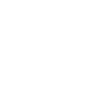

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Mask Vector and Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C
    
# 2. Plot (4 x 4 subfigures)
def plot(samples):
    fig = plt.figure(figsize = (5,5))
    gs = gridspec.GridSpec(5,5)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28,28), cmap='Greys_r')
        
    return fig

#%% 3. Others
# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 1., size = [m, n])


def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx


class NetD(torch.nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.fc1 = torch.nn.Linear(Dim*2, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()
    
    
    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]
        
        
    def forward(self, x, m, g, h):
        """Eq(3)"""
        inp = m * x + (1-m) * g 
        inp = torch.cat((inp, h), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
#         out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        out = self.fc3(out)
        
        return out    

"""
Eq(2)
"""
class NetG(torch.nn.Module):
    def __init__(self):
        super(NetG, self).__init__()
        self.fc1 = torch.nn.Linear(Dim*2, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()
    
    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]
        
        
    def forward(self, x, z, m):
        inp = m * x + (1-m) * z
        inp = torch.cat((inp, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
#         out = self.fc3(out)
        
        return out 





netD = NetD()
netG = NetG()


optimD = torch.optim.Adam(netD.parameters(), lr=0.001)
optimG = torch.optim.Adam(netG.parameters(), lr=0.001)


# Output Initialization
if not os.path.exists('Multiple_Impute_out1/'):
    os.makedirs('Multiple_Impute_out1/')


bce_loss = torch.nn.BCEWithLogitsLoss(reduction="elementwise_mean")
mse_loss = torch.nn.MSELoss(reduction="elementwise_mean")

i = 1
#%% Start Iterations
for it in range(10000): 
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    Z_mb = sample_Z(mb_size, Dim) 
    
    M_mb = trainM[mb_idx,:]  
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1 + 0.5*(1-H_mb1)
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    X_mb = torch.tensor(X_mb).float()
    New_X_mb = torch.tensor(New_X_mb).float()
    Z_mb = torch.tensor(Z_mb).float()
    M_mb = torch.tensor(M_mb).float()
    H_mb = torch.tensor(H_mb).float()
    
    # Train D
    G_sample = netG(X_mb, New_X_mb, M_mb)
    D_prob = netD(X_mb, M_mb, G_sample, H_mb)
    D_loss = bce_loss(D_prob, M_mb)
    
    D_loss.backward()
    optimD.step()
    optimD.zero_grad()
    
    # Train G
    G_sample = netG(X_mb, New_X_mb, M_mb)
    D_prob = netD(X_mb, M_mb, G_sample, H_mb)
    D_prob.detach_()
    G_loss1 = ((1 - M_mb) * (torch.sigmoid(D_prob)+1e-8).log()).mean()/(1-M_mb).sum()
    G_mse_loss = mse_loss(M_mb*X_mb, M_mb*G_sample) / M_mb.sum()
    G_loss = G_loss1 + alpha*G_mse_loss
    
    G_loss.backward()
    optimG.step()
    optimG.zero_grad()
    
    G_mse_test = mse_loss((1-M_mb)*X_mb, (1-M_mb)*G_sample) / (1-M_mb).sum()
    
  #%% Output figure
    if it % 100 == 0:
      
        mb_idx = sample_idx(Test_No, 5)
        X_mb = testX[mb_idx,:]
        M_mb = testM[mb_idx,:]  
        Z_mb = sample_Z(5, Dim) 
        
        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb
        
        X_mb = torch.tensor(X_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()
        Z_mb = torch.tensor(Z_mb).float()
        M_mb = torch.tensor(M_mb).float()
        
        samples1 = X_mb                
        samples5 = M_mb * X_mb + (1-M_mb) * Z_mb
        
        samples2 = netG(X_mb, New_X_mb, M_mb)
        samples2 = M_mb * X_mb + (1-M_mb) * samples2        
        
        Z_mb = torch.Tensor(sample_Z(5, Dim)).float()
        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  
        
        samples3 =netG(X_mb, New_X_mb, M_mb)
        samples3 = M_mb * X_mb + (1-M_mb) * samples3     
        
        Z_mb = torch.tensor(sample_Z(5, Dim)).float()
        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb       
        samples4 = netG(X_mb, New_X_mb, M_mb)
        samples4 = M_mb * X_mb + (1-M_mb) * samples4     
        
        
        samples = np.vstack([samples5.detach().data, samples2.detach().data, samples3.detach().data,
                             samples4.detach().data, samples1.detach().data])          
        
        fig = plot(samples)
        plt.savefig('Multiple_Impute_out1/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        
    #%% Intermediate Losses
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'.format(D_loss))
        print('Train_loss: {:.4}'.format(G_mse_loss))
        print('Test_loss: {:.4}'.format(G_mse_test))
        print()